In [2]:
!pip install pyECLAT upsetplot
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from pyECLAT import ECLAT

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for upsetplot: filename=upsetplot-0.9.0-py3-none-any.whl size=24866 sha256=173ab38be59186a48c82fc5455951132d1663e99802d4d5460ef7c9e5efe1d64
  Stored in directory: /root/.cache/pip/wheels/5d/7a/54/1460364da0fe4e17c256b7a28191fa373d81292fcf73a4ddb8
Successfully built upsetplot


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Groceries_dataset.csv')

print(df.head())
print(df.info())

print(f"Unique Items: {df['itemDescription'].nunique()}")
print(f"Unique Members: {df['Member_number'].nunique()}")
print(f"Unique Dates: {df['Date'].nunique()}")

   Member_number        Date   itemDescription
0           1808  21-07-2015    tropical fruit
1           2552  05-01-2015        whole milk
2           2300  19-09-2015         pip fruit
3           1187  12-12-2015  other vegetables
4           3037  01-02-2015        whole milk
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB
None
Unique Items: 167
Unique Members: 3898
Unique Dates: 728


In [4]:
from collections import defaultdict

# Step 1: Group transactions by Member + Date
transactions = df.groupby(
    ['Member_number', 'Date']
)['itemDescription'].apply(list).reset_index()

transactions['itemList'] = transactions['itemDescription'].apply(
    lambda items: [str(x).strip() for x in items]
)

# Step 2: Build vertical data = item → set of transaction indices
vertical_data = defaultdict(set)

for idx, row in transactions.iterrows():
    items = set(row['itemDescription'])  # ensure unique items per transaction
    for item in items:
        vertical_data[item].add(idx)

# Print vertical data example
for item, tids in vertical_data.items():
    print(f"{item} → {tids}")

# vertical_data now looks like:
# milk → {0, 3, 7}, bread → {0, 2, 4}, ...
# where the set values are indices of the transactions list

yogurt → {0, 8194, 8202, 8213, 33, 34, 35, 8227, 44, 46, 8249, 58, 71, 81, 83, 92, 101, 8293, 8300, 8303, 118, 8318, 127, 132, 136, 8329, 8335, 146, 149, 8341, 8353, 162, 8367, 176, 180, 189, 8384, 195, 208, 8406, 216, 8410, 8414, 229, 8426, 249, 8447, 256, 260, 8458, 8462, 8464, 8468, 8475, 288, 290, 8487, 8490, 301, 8497, 8499, 8508, 317, 319, 320, 322, 325, 8519, 8520, 8525, 338, 347, 8541, 8545, 358, 8553, 366, 368, 371, 372, 373, 376, 8582, 8584, 394, 8587, 400, 8596, 408, 417, 418, 8609, 8625, 434, 8626, 8630, 446, 8641, 451, 8647, 469, 475, 480, 486, 8680, 8687, 8696, 512, 8720, 538, 546, 547, 550, 551, 8747, 8749, 8750, 8753, 8754, 571, 579, 8773, 584, 590, 594, 8801, 8814, 644, 647, 8840, 8843, 8847, 8860, 8862, 8873, 8877, 8888, 8892, 8905, 8911, 720, 721, 735, 737, 741, 746, 751, 758, 8950, 760, 764, 777, 779, 8974, 788, 8982, 8993, 806, 8999, 9000, 9001, 820, 837, 848, 9048, 869, 874, 9081, 900, 901, 9098, 9115, 931, 933, 9128, 9135, 949, 9148, 959, 9154, 9180, 9184, 994, 9

In [5]:
eclat_data = pd.DataFrame(transactions['itemList'].tolist())

In [6]:
from pyECLAT import ECLAT

eclat = ECLAT(data=eclat_data, verbose=True)
min_support = 0.03

freq_itemsets, support_dict = eclat.fit(
    min_support=min_support,
    min_combination=2,
    max_combination=4
)

100%|██████████| 168/168 [00:00<00:00, 5734.12it/s]


Combination 2 by 2


351it [00:05, 65.46it/s]


Combination 3 by 3


2925it [00:46, 62.51it/s]


Combination 4 by 4


17550it [04:36, 63.44it/s]


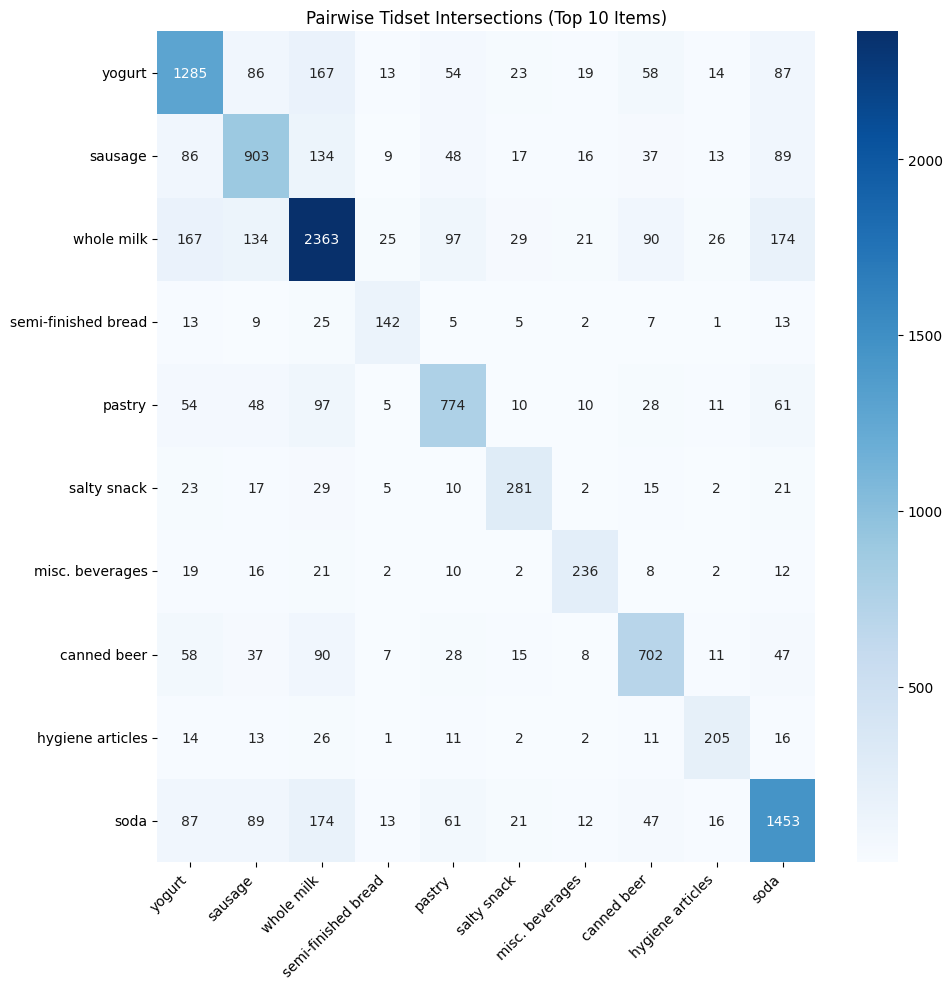

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Take only the first 10 items from vertical_data
top_items = list(vertical_data.keys())[:10]
n = len(top_items)

# Build matrix of intersection sizes for just those 10
matrix = np.zeros((n, n), dtype=int)

for i in range(n):
    for j in range(n):
        if i <= j:  # fill symmetrically
            intersection = vertical_data[top_items[i]].intersection(vertical_data[top_items[j]])
            matrix[i, j] = matrix[j, i] = len(intersection)

# Plot heatmap
plt.figure(figsize=(10, 10))  # square shape works better for 10×10
sns.heatmap(
    matrix,
    annot=True,
    fmt="d",
    xticklabels=top_items,
    yticklabels=top_items,
    cmap="Blues"
)
plt.title("Pairwise Tidset Intersections (Top 10 Items)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

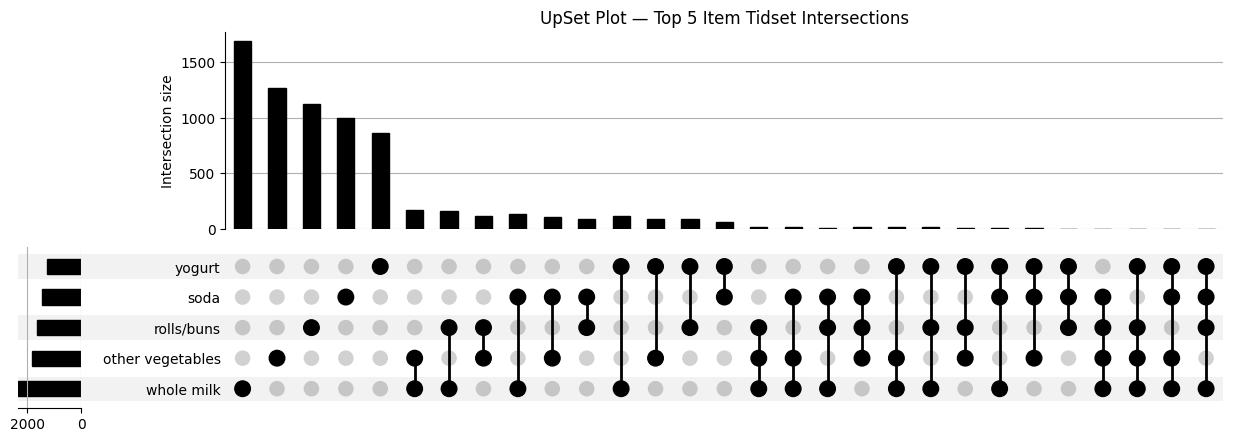

In [10]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.pyplot as plt
from upsetplot import from_contents, plot

# 1) Get the top 10 items by support (largest tidsets)
top_5_items = sorted(
    vertical_data.keys(),
    key=lambda i: len(vertical_data[i]),
    reverse=True
)[:5]

# 2) Build contents only for these top items
contents_top5 = {item: list(vertical_data[item]) for item in top_5_items}

# 3) Create UpSet‑plot data
upset_data_top5 = from_contents(contents_top5)

# 4) Plot
plot(upset_data_top5)
plt.title("UpSet Plot — Top 5 Item Tidset Intersections")
plt.show()

In [11]:
from functools import partial

# global counter to stop after printing 10 itemsets
counter = {"count": 0}

def print_eclat_tree_limited(prefix, items, vertical_data, min_support, limit, counter):
    # Stop recursion if limit reached
    if counter["count"] >= limit:
        return

    for i, item in enumerate(items):
        # Stop early if we’ve printed enough
        if counter["count"] >= limit:
            return

        new_prefix = prefix + [item]

        # determine tidset for this new itemset
        if len(prefix) == 0:
            current_tidset = vertical_data[item]
        else:
            prefix_tidset = set.intersection(*(vertical_data[x] for x in prefix))
            current_tidset = prefix_tidset & vertical_data[item]

        # check support
        if len(current_tidset) >= min_support:
            print(f"{new_prefix} (support={len(current_tidset)})")
            counter["count"] += 1

            # if we still haven’t hit the limit, recurse to expand itemsets
            if counter["count"] < limit:
                print_eclat_tree_limited(
                    new_prefix,
                    items[i+1:],
                    vertical_data,
                    min_support,
                    limit,
                    counter
                )

# run the limited tree
print("First 10 Frequent Itemsets in ECLAT DFS Order (min_support={}):".format(min_support))
print_eclat_tree_limited([], list(vertical_data.keys()), vertical_data, min_support, 10, counter)

First 10 Frequent Itemsets in ECLAT DFS Order (min_support=0.03):
['yogurt'] (support=1285)
['yogurt', 'sausage'] (support=86)
['yogurt', 'sausage', 'whole milk'] (support=22)
['yogurt', 'sausage', 'whole milk', 'semi-finished bread'] (support=2)
['yogurt', 'sausage', 'whole milk', 'semi-finished bread', 'other vegetables'] (support=1)
['yogurt', 'sausage', 'whole milk', 'pastry'] (support=2)
['yogurt', 'sausage', 'whole milk', 'pastry', 'curd'] (support=1)
['yogurt', 'sausage', 'whole milk', 'pastry', 'curd', 'rolls/buns'] (support=1)
['yogurt', 'sausage', 'whole milk', 'pastry', 'curd', 'rolls/buns', 'dessert'] (support=1)
['yogurt', 'sausage', 'whole milk', 'pastry', 'curd', 'dessert'] (support=1)
